<a href="https://colab.research.google.com/github/pedrosena138/imdb-sentiment-analysis/blob/main/IMDB_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

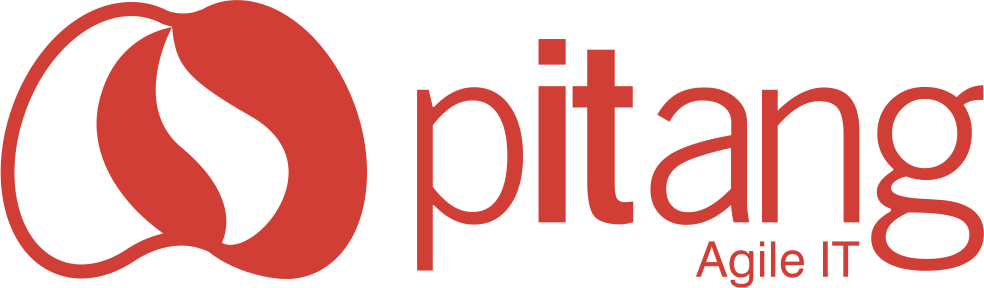

# Análise de Sentimento da IMDB
> Implementando um modelo de linguagem para análise de sentimenTo da base de dados IMDB utilizando o Huggingface e o Tensorflow

Antes de iniciar é necessário ativar a GPU do ambiente para uma melhor performance. Para fazer isso basta ir no menu:  

Editar -> Configurações de notebook -> Acelerador de hardware -> selecionar a opção GPU

![](https://th.bing.com/th/id/OIP.WSRXF4Xni-Ch18U9BnHdCQHaHa?w=195&h=195&c=7&r=0&o=5&pid=1.7) ![](https://th.bing.com/th/id/OIP.LRW8UBZq8iNKoOHLgCK2MwHaEK?w=297&h=180&c=7&r=0&o=5&pid=1.7)

## 1. Setup

Instalando bibliotecas do Huggingface

In [1]:
!pip install datasets transformers evaluate xformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.1/109.1 MB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 22.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 106.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.8 MB/s eta 0:00:00


Importando bibliotecas para o notebook. Algumas bibliotecas já vem pré-instaladas como Pandas, Scikit-learn, Numpy, etc.

In [2]:
import os
import random
from transformers import TFAutoModelForSequenceClassification, AutoTokenizer, DataCollatorWithPadding, create_optimizer, pipeline, set_seed
from datasets import load_dataset
import tensorflow as tf
import evaluate

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Configura valor padrão para geração de valores pseudoaleatórios

In [3]:
seed_value= 42
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
set_seed(seed_value)

## 2. Base de Dados

A base de dados selecionada a IMDB (Internet Movie Database) que contem reviews de filmes junto com uma classificação de POSITIVA (1) ou NEGATIVA (0).

In [14]:
dataset = load_dataset('imdb')

print('\nText:', dataset['train'][0]['text'])
print('Label:', dataset['train'][0]['label'])

  0%|          | 0/3 [00:00<?, ?it/s]


Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwe

## 3. Pré-processamento

Antes de utilizar a base de dados para treinar nosso modelo, é necessário realizar um pré-processamento dos dados para que o modelo seja capaz de entender os dados. A quantidade de etapas dessa fase irá depender da base de dados utilizada, quanto melhor for a qualidade dos dados, menos ajustes serão necessários.

Nosso modelo de linguagem precisa de um "tokenizador" para transformar as palavras em uma sequencia de números. Além disso a base de dados foi separada em treinamento, validação e teste

In [27]:
tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

def preprocess_dataset(dataset):
  processed_dataset = dataset.map(preprocess_function, batched=True)
  train_dataset = processed_dataset['train'].shuffle(seed_value)

  split_dataset = processed_dataset['test'].train_test_split(test_size=0.3, seed=seed_value)
  val_dataset = split_dataset['train']
  test_dataset = split_dataset['test']

  return train_dataset, val_dataset, test_dataset


encode_text = tokenizer.encode(dataset['train'][0]['text'])
decode = tokenizer.batch_decode(encode_text)
print('Encoded Text:', encode_text)
print('Decoded Text:', decode)

Encoded Text: [101, 1045, 12524, 1045, 2572, 8025, 1011, 3756, 2013, 2026, 2678, 3573, 2138, 1997, 2035, 1996, 6704, 2008, 5129, 2009, 2043, 2009, 2001, 2034, 2207, 1999, 3476, 1012, 1045, 2036, 2657, 2008, 2012, 2034, 2009, 2001, 8243, 2011, 1057, 1012, 1055, 1012, 8205, 2065, 2009, 2412, 2699, 2000, 4607, 2023, 2406, 1010, 3568, 2108, 1037, 5470, 1997, 3152, 2641, 1000, 6801, 1000, 1045, 2428, 2018, 2000, 2156, 2023, 2005, 2870, 1012, 1026, 7987, 1013, 1028, 1026, 7987, 1013, 1028, 1996, 5436, 2003, 8857, 2105, 1037, 2402, 4467, 3689, 3076, 2315, 14229, 2040, 4122, 2000, 4553, 2673, 2016, 2064, 2055, 2166, 1012, 1999, 3327, 2016, 4122, 2000, 3579, 2014, 3086, 2015, 2000, 2437, 2070, 4066, 1997, 4516, 2006, 2054, 1996, 2779, 25430, 14728, 2245, 2055, 3056, 2576, 3314, 2107, 2004, 1996, 5148, 2162, 1998, 2679, 3314, 1999, 1996, 2142, 2163, 1012, 1999, 2090, 4851, 8801, 1998, 6623, 7939, 4697, 3619, 1997, 8947, 2055, 2037, 10740, 2006, 4331, 1010, 2016, 2038, 3348, 2007, 2014, 3689, 383

In [28]:
train_dataset, val_dataset, test_dataset = preprocess_dataset(dataset)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

## 4. Treinamento

In [35]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {value: key for key, value in id2label.items()}

batch_size = 16
num_epochs = 3
batches_per_epoch = len(train_dataset) // batch_size
total_train_steps = int(batches_per_epoch * num_epochs)

optimizer, schedule = create_optimizer(init_lr=2e-5, num_warmup_steps=0, num_train_steps=total_train_steps)

model = TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                          num_labels=2,
                                          id2label=id2label,
                                          label2id=label2id)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Converter as bases de dados para um formato otimizado para o TensorFlow

In [36]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_set = model.prepare_tf_dataset(
    train_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_val_set = model.prepare_tf_dataset(
    val_dataset,
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)

tf_test_set = model.prepare_tf_dataset(
    test_dataset,
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [39]:
model.compile(optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x=tf_train_set, validation_data=tf_val_set, epochs=num_epochs, batch_size=batch_size)

Epoch 1/3
1562/1562 [==============================] - 1781s 1s/step - loss: 0.2298 - accuracy: 0.9081 - val_loss: 0.1773 - val_accuracy: 0.9317
Epoch 2/3
1562/1562 [==============================] - 1744s 1s/step - loss: 0.1196 - accuracy: 0.9577 - val_loss: 0.1974 - val_accuracy: 0.9318
Epoch 3/3
1562/1562 [==============================] - 1745s 1s/step - loss: 0.0625 - accuracy: 0.9808 - val_loss: 0.2182 - val_accuracy: 0.9323


In [40]:
history.history

{'loss': [0.22983893752098083, 0.11957760155200958, 0.06248832494020462],
 'accuracy': [0.9081305861473083, 0.9577465057373047, 0.9807538390159607],
 'val_loss': [0.17727026343345642, 0.19735798239707947, 0.21822507679462433],
 'val_accuracy': [0.9316674470901489, 0.9317817687988281, 0.9322964549064636]}

## 5. Teste

Após o treinamento temos que testar o modelo com dados que ele desconhece antes de colocá-lo em produção.

In [42]:
results = model.evaluate(tf_test_set)

469/469 [==============================] - 143s 304ms/step - loss: 0.2336 - accuracy: 0.9289


In [43]:
results

[0.23362240195274353, 0.928933322429657]

## 6. API

O Huggingface possui uma API onde é possível testar os modelos em diferentes tarefas sem precisar executá-las na sua máquina

In [52]:
my_classifier = pipeline('sentiment-analysis', model, tokenizer=tokenizer)
api_classifier = pipeline(
    'sentiment-analysis',
    model=TFAutoModelForSequenceClassification.from_pretrained('distilbert-base-uncased',
                                                               num_labels=2,
                                                               id2label=id2label,
                                                               label2id=label2id
                                                               ),
    tokenizer=tokenizer)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

In [73]:
positive_example = 'This film is very good'
negative_example = 'This film is very bad'
sarcasm_example = "This film is good if you like to waste your time, I don't have any reason to watch again"

my_classifications = my_classifier([positive_example, negative_example, sarcasm_example])
api_classifications = api_classifier([positive_example, negative_example, sarcasm_example])

In [74]:
print('Positive Example')
print('\tText:', positive_example)
print('\tMy model classfication:', my_classifications[0]['label'], 'with {}% chance'.format(round((my_classifications[0]['score'] * 100), 2)))
print('\tAPI model classfication:', api_classifications[0]['label'], 'with {}% chance'.format(round((api_classifications[0]['score'] * 100), 2)))

print('\nNegative Example')
print('\tText:', negative_example)
print('\tMy model classfication:', my_classifications[1]['label'], 'with {}% chance'.format(round((my_classifications[1]['score'] * 100), 2)))
print('\tAPI model classfication:', api_classifications[1]['label'], 'with {}% chance'.format(round((api_classifications[1]['score'] * 100), 2)))

print('\nSarcasm Example')
print('\tText:', sarcasm_example)
print('\tMy model classfication:', my_classifications[2]['label'], 'with {}% chance'.format(round((my_classifications[2]['score'] * 100), 2)))
print('\tAPI model classfication:', api_classifications[2]['label'], 'with {}% chance'.format(round((api_classifications[2]['score'] * 100), 2)))

Positive Example
	Text: This film is very good
	My model classfication: POSITIVE with 99.24% chance
	API model classfication: POSITIVE with 51.39% chance

Negative Example
	Text: This film is very bad
	My model classfication: NEGATIVE with 99.18% chance
	API model classfication: POSITIVE with 50.97% chance

Sarcasm Example
	Text: This film is good if you like to waste your time, I don't have any reason to watch again
	My model classfication: NEGATIVE with 99.14% chance
	API model classfication: NEGATIVE with 50.37% chance


## Referências

[Documentação do Huggingface](https://huggingface.co/docs/transformers/index)  
[Documentação TensorFlow](https://www.tensorflow.org/hub/tutorials?hl=pt-br)